# Supervised learning on an imbalanced dataset

We are interested in studying why some students majoring in mathematics at a university decide to change their major, with a view towards *increasing retention in the math major*.

Our dataset contains about 15,000 observations recording how a particular student performed in a given class, and whether the student subsequently dropped the math major immediately after completing the course.

This is a deliberately simple synthetic dataset created as a toy model for analysis.  It's a little noisy but we use it to demonstrate the workflow for modeling using supervised learning.

Here are a few rows from the dataset:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

STUDENTS = pd.read_csv("STUDENTS.csv")
STUDENTS

,Course,Grade,Gender,DROP
0,225,2,0,1
1,240,4,1,1
2,240,4,1,1
3,240,4,1,1
4,240,4,1,1
...,...,...,...,...
15504,495,4,1,0
15505,495,4,0,0
15506,495,4,0,0
15507,495,3,0,0


**Each observation represents a grade received by a student in a particular course.**

The grades are encoded with values A=4, B=3, C=2, D=1, and F=0.  Students who withdrew or did not complete the course are coded with Grade = -1.  The codes for student Gender are Male = 0 and Female = 1.

The DROP column is the target of our analysis.  It equals 1 when the student **dropped the math major immediately after taking this course** (and equals 0 otherwise).  

One of the challenges with this dataset is that the observations where the student dropped the major are *rare* events (about 2% overall), a characteristic shared by problems like detecting credit card fraud or spam email.


In [2]:
STUDENTS.DROP.value_counts()

0    15188
1      321
Name: DROP, dtype: int64

## Exploratory data analysis

Let's start by creating some summary statistics to visualize the data for the two groups (those who dropped and those who didn't) separately.

To do this, we create a new dataframe indexed by the course number, containing the grade and gender distributions for each group.


In [3]:
dropped = STUDENTS.loc[STUDENTS.DROP == 1]
student = STUDENTS.loc[STUDENTS.DROP == 0]

df = (dropped.groupby(["Gender","Course"]).count())
df = df.reset_index()
df_gender = df.pivot(index='Course', columns='Gender', values='DROP').fillna(0).reset_index().set_index("Course").astype(int)
df_gender.columns = ["Males", "Females"]
df = (dropped.groupby(["Grade","Course"]).count())
df = df.reset_index()
df_grade = df.pivot(index='Course', columns='Grade', values='DROP').fillna(0).reset_index().set_index("Course").astype(int)
df_grade.columns = ["W","F","D","C","B","A"]
ddf = pd.concat([df_grade,df_gender], axis=1)

df = (student.groupby(["Gender","Course"]).count())
df = df.reset_index()
df_gender = df.pivot(index='Course', columns='Gender', values='DROP').fillna(0).reset_index().set_index("Course").astype(int)
df_gender.columns = ["Males", "Females"]
df = (student.groupby(["Grade","Course"]).count())
df = df.reset_index()
df_grade = df.pivot(index='Course', columns='Grade', values='DROP').fillna(0).reset_index().set_index("Course").astype(int)
df_grade.columns = ["W","F","D","C","B","A"]
sdf = pd.concat([df_grade,df_gender], axis=1)
sdf.columns = ["W_a", "F_a", "D_a", "C_a", "B_a", "A_a", "Male", "Female"]

COURSES = pd.concat([ddf,sdf],axis=1)
COURSES["Total"] = COURSES.Males + COURSES.Females
COURSES["Total_t"] = COURSES.Male + COURSES.Female
COURSES["Course"] = COURSES.index.astype(str)
COURSES.head(5)

,W,F,D,C,B,A,Males,Females,W_a,F_a,D_a,C_a,B_a,A_a,Male,Female,Total,Total_t,Course
Course,,,,,,,,,,,,,,,,,,,
225,0,0,0,1,0,0,1,0,36,22,22,109,65,41,251,44,1,295,225
240,0,1,1,10,8,7,4,23,183,210,261,734,808,483,1494,1185,27,2679,240
241,0,0,1,5,5,4,2,13,98,77,137,411,457,281,830,631,15,1461,241
242,0,1,0,0,0,1,0,2,29,39,72,152,134,70,140,356,2,496,242
243,0,0,0,1,0,0,0,1,8,14,51,77,93,39,82,200,1,282,243


The first set of columns in this dataframe contains totals for students who dropped the major while the second set of columns the totals for students who did not drop the major.

Comparing a plot of the grade distributions for the two groups, we see that the students who dropped have slightly higher rates of C's, D's, and F's (although not withdrawals).

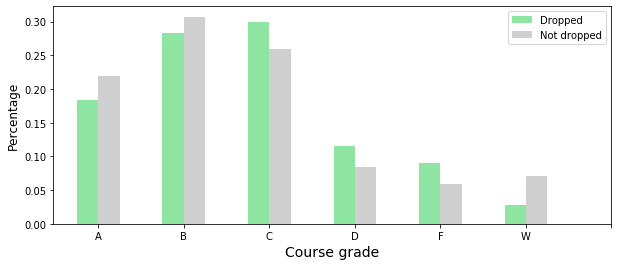

In [4]:
bar_width = 0.25
r1 = np.arange(6)
r2 = [x + bar_width for x in r1]
b1 = COURSES.loc[:,['A','B','C','D','F','W']].sum()
b2 = COURSES.loc[:,['A_a','B_a','C_a','D_a','F_a','W_a']].sum()
plt.figure(figsize=(10,4))
plt.bar(r1, b1/sum(b1), width=bar_width, color = sns.color_palette('pastel')[2], label='Dropped')
plt.bar(r2, b2/sum(b2), width=bar_width, color = sns.color_palette('pastel')[7], label='Not dropped')
plt.xticks([r + bar_width/2 for r in range(7)], ['A', 'B', 'C', 'D', 'F', 'W'])
plt.ylabel('Percentage', fontsize=12)
plt.xlabel('Course grade', fontsize=14)
plt.legend()
plt.show()

As might be expected, the mean GPA is slightly lower for the students who dropped.  It also appears that students who drop tend to be Female.  (Hypothesis tests for the GPA means being distinct have p-values well below 0.01, but this may be due to the relatively large sample size of students who did not drop.)

In [5]:
from scipy.stats import ttest_ind

ddist = STUDENTS.loc[(STUDENTS.DROP==1) & (STUDENTS.Grade!=-1)].Grade
adist = STUDENTS.loc[(STUDENTS.DROP==0) & (STUDENTS.Grade!=-1)].Grade
print('GPA[ No drop ]:  mean {:.4} standard deviation {:.4}'.format(adist.mean(), adist.std()))
print('GPA[ Dropped ]:  mean {:.4} standard deviation {:.4}'.format(ddist.mean(), ddist.std()))
_, pval = ttest_ind(ddist, adist, equal_var=False)  # 2-sided, independent 
print("t-test for difference in means:  p-value",pval)
print()
ddist = STUDENTS.loc[(STUDENTS.DROP==1)].Gender
adist = STUDENTS.loc[(STUDENTS.DROP==0)].Gender
print('GENDER[ No drop ]:  mean {:.4} standard deviation {:.4}'.format(adist.mean(), adist.std()))
print('GENDER[ Dropped ]:  mean {:.4} standard deviation {:.4}'.format(ddist.mean(), ddist.std()))
_, pval = ttest_ind(ddist, adist, equal_var=False)  # 2-sided, independent 
print("t-test for difference in means:  p-value",pval)

GPA[ No drop ]:  mean 2.586 standard deviation 1.13
GPA[ Dropped ]:  mean 2.365 standard deviation 1.187
t-test for difference in means:  p-value 0.0012939742671504062

GENDER[ No drop ]:  mean 0.3888 standard deviation 0.4875
GENDER[ Dropped ]:  mean 0.5732 standard deviation 0.4954
t-test for difference in means:  p-value 1.5963113689334478e-10


Much of the intricacy of this dataset is contained in the course information.  Restricting solely to the students who dropped, we find the grade and gender distributions broken down by course.  This gives a more fine-grained view into the GPA and gender differences we found.

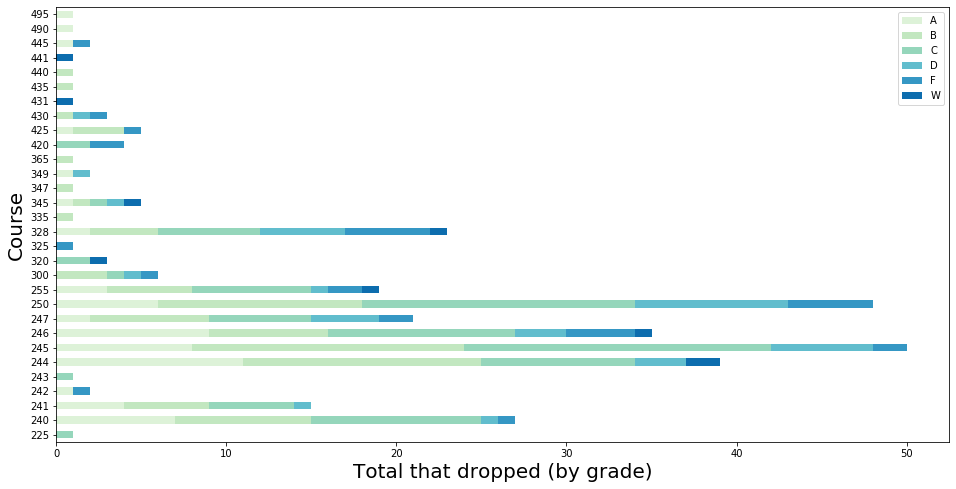

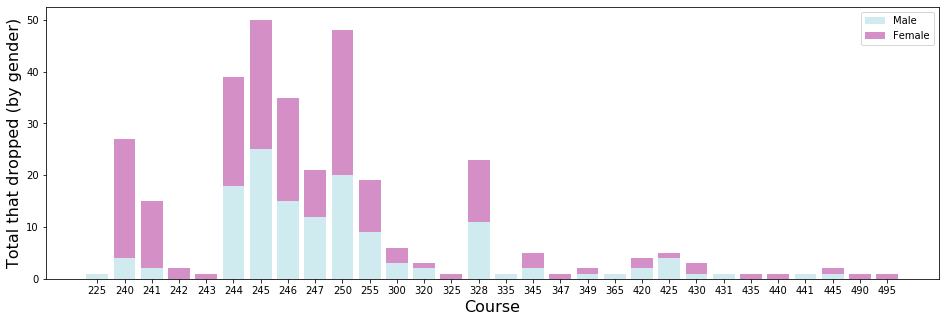

In [6]:
#  Grade distributions by course, absolute counts
COURSES.loc[:,['A','B','C','D','F','W']].plot.barh(stacked=True, color=sns.color_palette("GnBu"), figsize=(16,8))
plt.ylabel('Course', fontsize=20)
plt.xlabel('Total that dropped (by grade)', fontsize=20)
plt.show()

#  Gender stacked chart, absolute counts
plt.figure(figsize=(16,5))
plt.bar(COURSES.Course, COURSES.Males, color=sns.color_palette("cubehelix", 8)[-1], label='Male')
plt.bar(COURSES.Course, COURSES.Females, bottom=COURSES.Males, color=sns.color_palette("cubehelix", 8)[-3], label='Female')
plt.ylabel('Total that dropped (by gender)', fontsize=16)
plt.xlabel('Course', fontsize=16)
plt.legend()
plt.show()

The plots above use raw counts for students who dropped.  To put these in context, we can also compute the **percentage** of students who dropped, again broken down by course.  We also plot the gender distribution for all students by course. 

From this perspective, two courses pop out (although 490 has very few students overall).

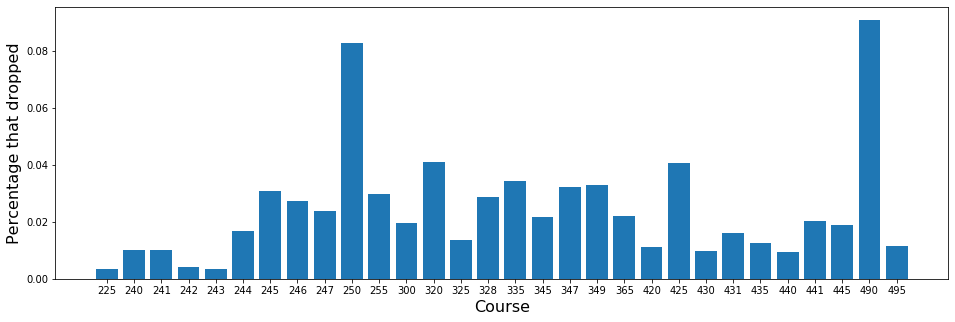

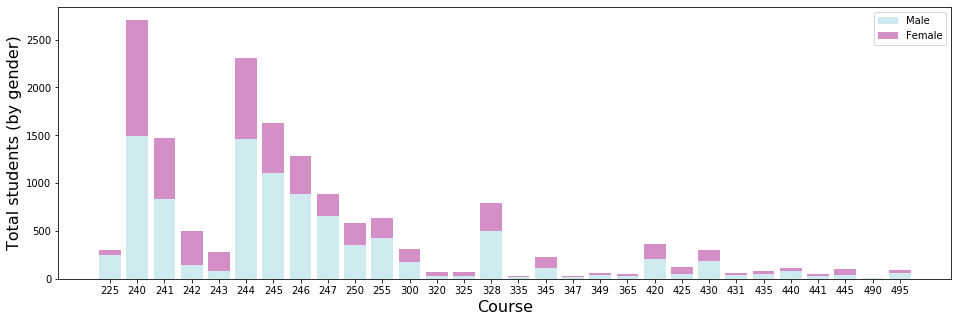

In [7]:
#  Drop _percentage_ by course
plt.figure(figsize=(16,5))
plt.bar(COURSES.Course, COURSES.Total/(COURSES.Total_t+COURSES.Total))
plt.ylabel('Percentage that dropped', fontsize=16)
plt.xlabel('Course', fontsize=16)
plt.show()

#  Gender stacked chart, absolute counts, all students
plt.figure(figsize=(16,5))
plt.bar(COURSES.Course, COURSES.Male + COURSES.Males, color=sns.color_palette("cubehelix", 8)[-1], label='Male')
plt.bar(COURSES.Course, COURSES.Female + COURSES.Females, bottom=COURSES.Male+COURSES.Males, color=sns.color_palette("cubehelix", 8)[-3], label='Female')
plt.ylabel('Total students (by gender)', fontsize=16)
plt.xlabel('Course', fontsize=16)
plt.legend()
plt.show()

Overall, these plots suggest some areas to investigate in order to increase retention in the major, although some of the data are contradictory.  For example, while there are gender imbalances in 240 and 241 students who drop that should be addressed, these courses do not rank very highly in the plot of overall drop percentages.  Even for this simple dataset, the predictor variables interact in complicated ways.

We can see that it might be difficult to formulate a targeted strategy for increasing retention using descriptive statistics alone.

# Machine learning models

Our next step might be to create a predictive model to identify students that are likely to drop, so that we can perform some kind of intervention.

We might do this on the level of individual students, in which case it would be enough to have a "black-box" model that takes information about a particular student and returns a prediction as to whether the student is likely to drop the major.

By contrast, if we wanted to perform a program-level intervention, then it would also be important to have a model whose internal parameters can be interpreted.

## Data splitting

The course and gender are categorical variables, so we use a "1-hot" or "dummy" variable encoding for these.

We also split the data into training and test sets.  Training data is used as input to the machine learning algorithm, and we will evaluate performance of the algorithm using the test set.


In [8]:
from sklearn.model_selection import train_test_split 

STUDENTS = pd.read_csv("STUDENTS.csv")
STUDENTS = pd.concat([STUDENTS, pd.get_dummies(STUDENTS.Course)], axis=1)
STUDENTS = pd.concat([STUDENTS, pd.get_dummies(STUDENTS.Gender)], axis=1)
STUDENTS.columns.values[-2] = "M"
STUDENTS.columns.values[-1] = "F"

X = STUDENTS.drop(['DROP', 'Course', 'Gender'], axis=1)
y = STUDENTS['DROP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [9]:
X_train.head(5)

,Grade,225,240,241,242,243,244,245,246,247,...,430,431,435,440,441,445,490,495,M,F
11559,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2855,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8249,3,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
8545,2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
8620,2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


## Scoring

To compare models, we define a function that returns a numeric score associated to the set of model predictions.

Our primary goal for this model is to reduce the **drop rate** for the math major (currently about 2%).  If we are currently performing no intervention, this is equivalent to a "null model" that always returns a prediction of DROP=0, regardless of the input.  We can use this model as a baseline for improvement.

Because the variable we are trying to detect is rare, the **accuracy rate** of our predictions is not the best way to evaluate a model.  To see this, consider the more refined information encoded by the "confusion matrix" containing counts of True Negatives (TN), False Positives (FP), False Negatives (FN), and True Positives (TP).  The accuracy rate is $\frac{TP+TN}{TP+FN+FP+TN}$ but our dataset contains many more Negatives than Positives.  Consequently, accuracy will be maximized by the null model, yet this will not help us solve our problem as there would be no reduction in drop rate.

In terms of the confusion matrix, the drop rate has the potential to be improved by $\frac{TP}{TP+FN}$, the accuracy rate restricted to positive observations.  This improvement comes at the expense of whatever work is required to perform interventions for False Positives.  That work is inversely related to $\frac{TN}{TN+FP}$, the accuracy rate restricted to negative observations, being $1 - \frac{FP}{TN+FP}$.

Thus, we define a custom **scoring function** that is the harmonic mean of these rates (in analogy with the way the F1-score is constructed).  The null model gets a score of 0, and a perfectly clairvoyant model that detects every drop with no false positives would score 1.  Realistic models will generate scores lying between these extremes.

In [10]:
def custom_score(cm, verbose=False):
    tn, fp, fn, tp = list(cm.flatten())
    if verbose:
        print("  (accuracy[DROP] = {:.4}  accuracy[NO DROP] = {:.4}  overall accuracy = {:.4})".format(tp/(tp+fn), tn/(tn+fp), (tp+tn)/(tp+tn+fp+fn)))
    a0 = tn/(tn+fp)
    a1 = tp/(tp+fn)
    return 2*(a0 * a1)/(a0 + a1)  # harmonic mean of the two rates 

## First ML model:  Logistic regression

Since the target variable is categorical, we might first try fitting the data using a logistic regression model...

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn.metrics as sm

l1_model = LogisticRegression()
l1_model = l1_model.fit(X_train, y_train)
predictions = l1_model.predict(X_test)

print("[ TN    FP ] = [ {:5}    {:5} ]\n[ FN    TP ]   [ {:5}    {:5} ] ".format( *list(confusion_matrix(y_test, predictions).flatten()) ))
print("score = ", custom_score(confusion_matrix(y_test, predictions), verbose=True))

[ TN    FP ] = [  7588        0 ]
[ FN    TP ]   [   167        0 ] 
  (accuracy[DROP] = 0.0  accuracy[NO DROP] = 1.0  overall accuracy = 0.9785)
score =  0.0


... and we get the null model:  every observation is categorized as "no drop."  This is almost 98% accurate, but useless for creating an intervention.

## First ML Model revised:  Imbalanced logistic regression

Luckily, there is a parameter we can pass to this algorithm to let it know the dataset is imbalanced...

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn.metrics as sm

l2_model = LogisticRegression(class_weight='balanced', max_iter=400)  # default is max_iter=100
l2_model = l2_model.fit(X_train, y_train)
predictions = l2_model.predict(X_test)

print(" [ TN    FP ] = [ {:5}    {:5} ]\n [ FN    TP ]   [ {:5}    {:5} ] ".format( *list(confusion_matrix(y_test, predictions).flatten()) ))
print("score = ", custom_score(confusion_matrix(y_test, predictions), verbose=True))


 [ TN    FP ] = [  5141     2447 ]
 [ FN    TP ]   [    75       92 ] 
  (accuracy[DROP] = 0.5509  accuracy[NO DROP] = 0.6775  overall accuracy = 0.6748)
score =  0.6076820439882491


... and now we get something that could be more workable.  This model correctly identifies more than half of the drops, so we have the potential to cut our drop rate by half (assuming the interventions are effective).  At the same time, there are some false positives that will create additional work (students flagged for intervention by the model even though they won't actually drop in reality).

One advantage of logistic regression is that the coefficients it fits that can be interpreted.  Here, we "open the black box" to determine the most important variables in this model.  This might be a starting point to define a program-level intervention, for example identifying the courses with the most potential to improve retention.

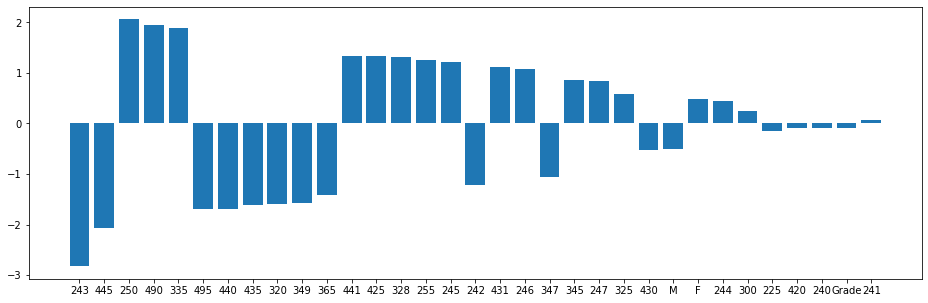

In [13]:
coeffs = pd.concat(map(lambda x : pd.Series(x), [X_train.columns.values.astype(str), l2_model.coef_.flatten(), np.abs(l2_model.coef_.flatten())]), axis=1)
coeffs = coeffs.sort_values(2, ascending=False).set_index(0)
plt.figure(figsize=(16,5))
plt.bar(coeffs.index, coeffs[1], align="center" )
plt.show()

Here, we've ordered the logistic regression coefficients by magnitude.  On the left, we obtain a list of courses that have the strongest propensity to push the prediction towards or away from drop (depending on the sign of the coefficient).  Interestingly, gender shows up among the course variables, but grade does not seem to have much predictive capability in this model.

## Second ML model:  Random Forest

Another common approach for categorical data is to fit an ensemble of "decision trees" to the observations in the dataset.  (We'll ignore how this model is implemented for the moment; there is a description near the bottom of this analysis illustrating one of these trees.)

For this model, we will need to deal with the imbalance in our data set explicitly.  (Without any adjustment, this algorithm will simply fit the null model.  There is a class_weight='balanced' option for this model but it didn't perform well on this dataset.)  

Here, we use "bootstrap" resampling to *increase the number of rare observations* in our training group.  It is important to **upsample** the training data only and carefully reserve the original test data for scoring the model.  

In [14]:
y_train.value_counts()

0    7600
1     154
Name: DROP, dtype: int64

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

def bootstrap_resampling(X_t, y_t, N_s=None):
    T = pd.concat([X_t, y_t], axis=1)
    no_drop = T[T.DROP==0]
    drop = T[T.DROP==1]
    if N_s == None:
        N_s = len(no_drop)
    n_samples_rare = N_s
    n_samples_common = N_s
    drop_upsampled = resample(drop, replace=True, n_samples=n_samples_rare)
    no_drop_downsampled = resample(no_drop, replace = False, n_samples = n_samples_common)
    resampled = pd.concat([no_drop_downsampled, drop_upsampled])
    resampled = resampled.sample(frac=1).reset_index(drop=True)  # shuffle the rows (for CV)
    yrs_train = resampled.DROP
    Xrs_train = resampled.drop('DROP', axis=1)
    return Xrs_train, yrs_train

rf_model = RandomForestClassifier()
Xrs_train, yrs_train = bootstrap_resampling(X_train, y_train)
rf_model = rf_model.fit(Xrs_train, yrs_train)
predictions = rf_model.predict(X_test)

print(" [ TN    FP ] = [ {:5}    {:5} ]\n [ FN    TP ]   [ {:5}    {:5} ] ".format( *list(confusion_matrix(y_test, predictions).flatten()) ))
print("score = ", custom_score(confusion_matrix(y_test, predictions), verbose=True))

 [ TN    FP ] = [  4944     2644 ]
 [ FN    TP ]   [    86       81 ] 
  (accuracy[DROP] = 0.485  accuracy[NO DROP] = 0.6516  overall accuracy = 0.648)
score =  0.5560934154287095


Hmmm.  Even with upsampling, this model didn't score as quite highly.

On the other hand, the RandomForestClassifier has various **hyper-parameters** that control how the algorithm fits data.  One of the simplest parameters we can try to tune is max_depth, the maximum depth of a tree created from the data.  We can try to improve this model by testing a variety of values for max_depth to see if there is an effect on the model score.

The usual way to do this would be to employ GridSearchCV cross-validation.  This involves splitting the training data into "folds," fitting a model using all but one of the folds, and testing how the model performed on the last fold.  That process is repeated for various values of the hyper-parameters.

However, because we are upsampling the rare observations in our training data, we need to be careful that upsampled observations don't show up in the fold we are using to score the cross-validation.  Consequently, we use KFold to implement **cross-validation with upsampling** on the training folds only, holding back an unaltered validation fold.

In [17]:
from sklearn.model_selection import KFold

def score_model(pmodel, params):
    cv = KFold(n_splits=2)
    scores = []
    for train_fold_index, valid_fold_index in cv.split(X_train, y_train):
        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train.iloc[train_fold_index]
        X_valid_fold, y_valid_fold = X_train.iloc[valid_fold_index], y_train.iloc[valid_fold_index]

        #  We only upsample the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = bootstrap_resampling(X_train_fold, y_train_fold)
        
        model_obj = pmodel(**params).fit(X_train_fold_upsample, y_train_fold_upsample)

        #  We score using NON-upsampled validation data
        score = custom_score(confusion_matrix(y_valid_fold, model_obj.predict(X_valid_fold)))
        scores.append(score)
    return np.array(scores)

Now we can plot the cross-validated scores we obtain with different values of max_depth...

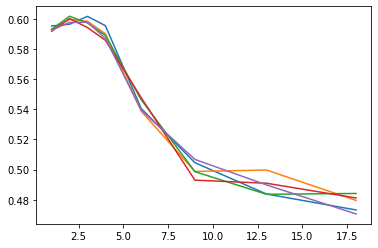

In [18]:
param_values = [1, 2, 3, 4, 6, 9, 13, 18]
for i in range(5):
    cv_curve = []
    for md in param_values:
        indiv_scores = []
        for _ in range(3):
            indiv_scores.append(  score_model(RandomForestClassifier, { 'max_depth': md, 'random_state':42 }).mean()  )
        cv_curve.append(pd.Series(indiv_scores).mean())
    plt.plot(param_values, cv_curve)
    #print (i, cv_curve)
plt.show()

It looks like max_depth values between 2 and 4 tend to produce the best scores on our training data.  (The model is likely overfitting the training data on deeper trees.)  

Next, we fit a RandomForestClassifier using max_depth = 3 and evaluate on the test data that we originally withheld...

In [19]:
model = RandomForestClassifier(max_depth = 3)
Xrs_train, yrs_train = bootstrap_resampling(X_train, y_train)
model = model.fit(Xrs_train, yrs_train)
predictions = model.predict(X_test)

print(" [ TN    FP ] = [ {:5}    {:5} ]\n [ FN    TP ]   [ {:5}    {:5} ] ".format( *list(confusion_matrix(y_test, predictions).flatten()) ))
print("score = ", custom_score(confusion_matrix(y_test, predictions), verbose=True))

 [ TN    FP ] = [  5015     2573 ]
 [ FN    TP ]   [    64      103 ] 
  (accuracy[DROP] = 0.6168  accuracy[NO DROP] = 0.6609  overall accuracy = 0.66)
score =  0.6380765736358364


... and we get an improved model -- that scores even higher than the logistic regression model!

## ROC curve analysis

Our models are capable of returning not only a 0/1 prediction for the DROP variable, but also provide an estimated "probability score" for each individual prediction.

Converting a probability into a classification prediction would normally be done by rounding (if the probability is < 0.5, then predict DROP = 0; if the probability is > 0.5, predict DROP = 1).  But by varying the 0.5 threshold, we can often obtain better results as we trade off true positives (accuracy on our rare events) against false positives (work required for unnecessary interventions).  The "ROC curve" plots all possible trade-offs by varying the threshold.

We provide a function to plot the "ROC" curve as well as the custom scores that are obtained at each threshold level.  The area under the ROC curve is often used as a metric for model selection.  Comparing the two models, we find that the tuned Random Forest model performs better.

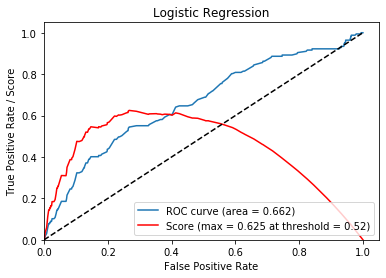

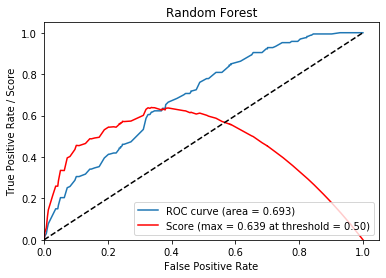

In [20]:
from sklearn.metrics import roc_curve, auc

def score_plot(name, y_true, y_score):
    #  y_score = probability of DROP=1, e.g. model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    # uses the same custom score function, just written in terms of true/false positive rates.
    scores = 2*tpr*(1-fpr)/(tpr+1-fpr)
    ms_index, max_score = max(enumerate(scores), key=lambda t : t[1])
    best_thresh = thresholds[ms_index]    
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot(fpr, 2*tpr*(1-fpr)/(tpr+1-fpr), color='r', label='Score (max = %0.3f at threshold = %0.2f)' % (max_score, best_thresh))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate / Score')
    plt.title(name)
    plt.legend(loc="lower right")
    plt.show()

score_plot("Logistic Regression", y_test, l2_model.predict_proba(X_test)[:,1])
score_plot("Random Forest", y_test, model.predict_proba(X_test)[:,1])

## Interpreting the Random Forest

"Opening the black box" for this ensemble of trees is a little more involved than for logistic regression but we can still obtain a measure of relative importance for each of the variables.

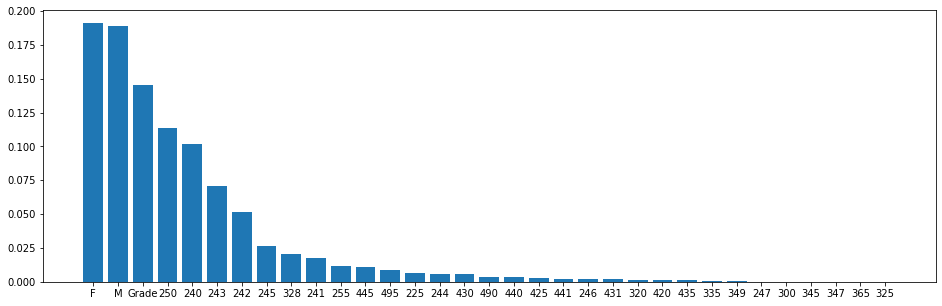

In [21]:
def plot_feature_importances(model, Xrs_train):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(16,5))
    plt.bar(Xrs_train.columns.astype(str).values[indices], importances[indices], align="center" )
    plt.show()

plot_feature_importances(model, Xrs_train)

Interestingly, this model ranks Grade as being highly predictive.  To understand how the model is using these features, we can fit a single decision tree and look at it in detail.

 [ TN    FP ] = [  4773     2815 ]
 [ FN    TP ]   [    63      104 ] 
  (accuracy[DROP] = 0.6228  accuracy[NO DROP] = 0.629  overall accuracy = 0.6289)
score =  0.6258713198419158


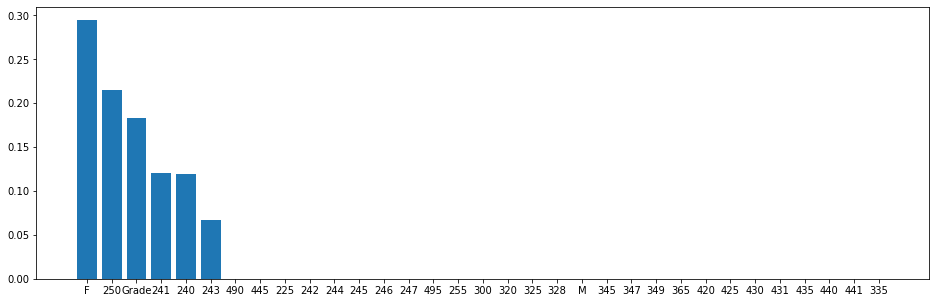

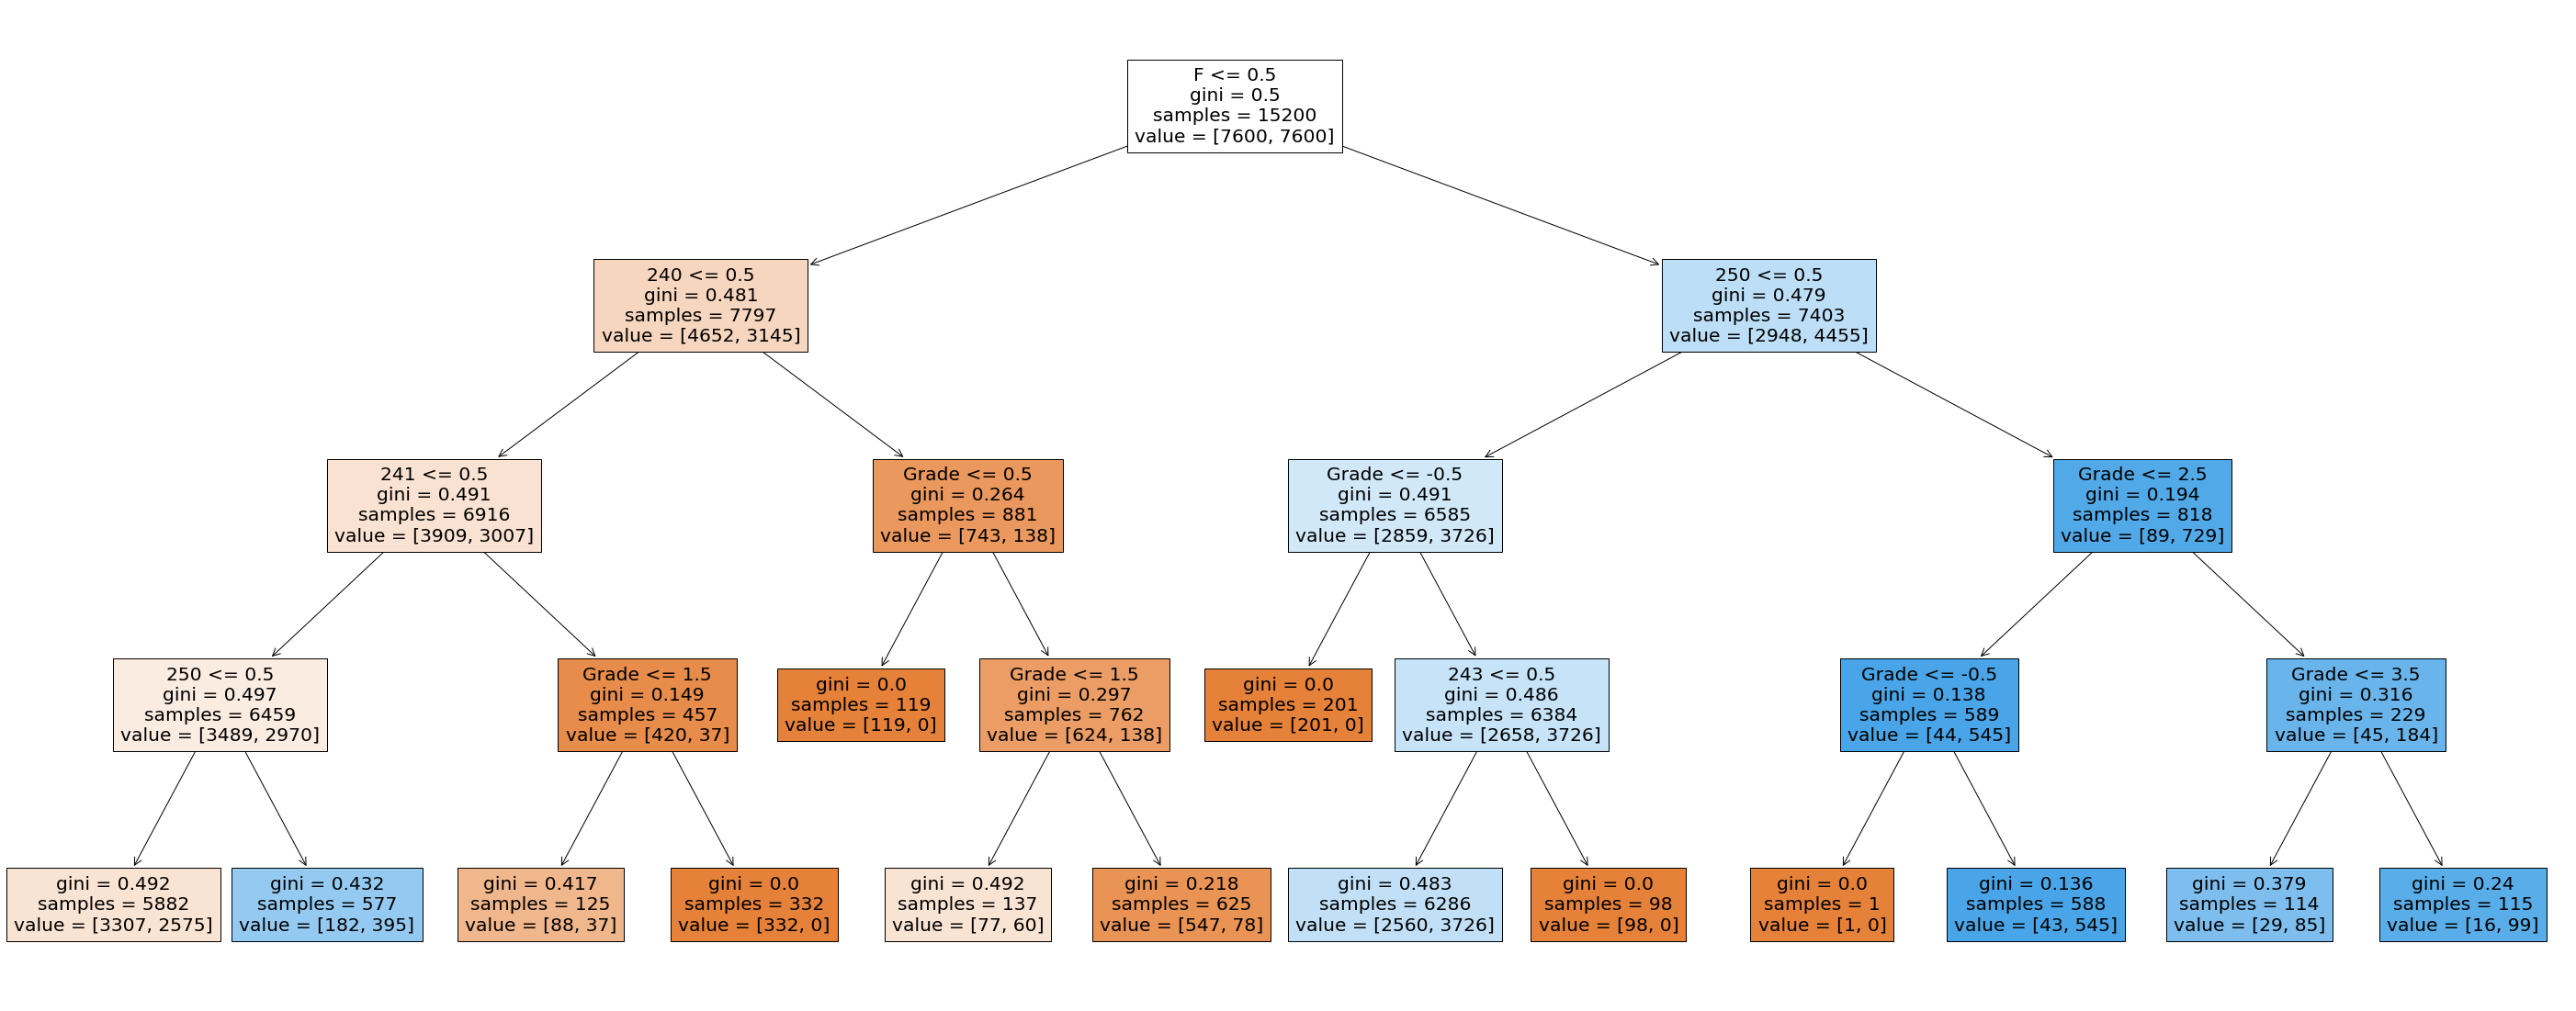

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

tree_model = DecisionTreeClassifier(max_depth=4)
tree_model = tree_model.fit(Xrs_train, yrs_train)
predictions = tree_model.predict(X_test)

print(" [ TN    FP ] = [ {:5}    {:5} ]\n [ FN    TP ]   [ {:5}    {:5} ] ".format( *list(confusion_matrix(y_test, predictions).flatten()) ))
print("score = ", custom_score(confusion_matrix(y_test, predictions), verbose=True))

plot_feature_importances(tree_model, Xrs_train)

plt.figure(figsize=(50,20))
_ = plot_tree(tree_model, feature_names=list(X.columns.values), filled=True)

## Interpreting the decision tree

Decision trees give a very intuitive model for prediction.  Each node represents a question we can ask about an observation.  If the answer is "yes" we follow the left path, otherwise we go right.  The "value" array shows the number of observations with DROP=0 and DROP=1, respectively, and the nodes are colored by which of these groups is dominant.  Hence, the blue leaves represent a drop prediction, and the tan nodes represent a no-drop prediction.

Several of the decisions based on Grade in this tree are just used to separate the withdrawals.  As a future direction, we may want to consider excluding these observations from our dataset and rerunning the analysis.

# Conclusion

We've fit a ML model to our dataset, and can use this to predict whether particular students are in danger of dropping the major.  For example, a Female student who is receiving a D in 250 receives the following prediction from our RandomForestClassifier model:

In [23]:
#  ['Grade', 225, 240, 241, 242, 243, 244, 245, 246, 247, 250, 255, 300, 320, 325, 328, 335, 345, 347, 349, 365, 420, 425, 430, 431, 435, 440, 441, 445, 490, 495, 'M', 'F'],
FC250 = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]).reshape(1, -1) 
print ( "Estimated probability of dropping the major = %0.2f." % model.predict_proba(FC250)[:,1][0] )

Estimated probability of dropping the major = 0.65.


Obviously, there are many additional directions to pursue in tuning the models we've considered as well as much more refined data we could include (what major are students changing to?  what was their performance in earlier math courses?  what advising have they received?  are there other relevant demographic factors?), but I hope this analysis shows how we might go beyond descriptive statistics and start to use machine learning models to build targeted interventions that improve programs.